In [109]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import StandardScaler

import tools

In [258]:
DATA_DIR = '/u/13/italinv1/unix/PycharmProjects/veera-thesis/aparc_data/'
AGG = 'max'
PSD_TYPE = 'relative'
BATCH_SIZE = 128
TEST_SPLIT = 0.2
DECIM_FREQS = 'bands'
RANDOM_SEED = 42
N_EPOCHS = 8
SKIP_TRAINING = False
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.001

cases = ['%03d' % n for n in range(28)]

freq_bands = [
    (1, 4),
    (4, 8),
    (8, 10),
    (10, 13),
    (13, 30),
    (30, 40)
]

In [3]:
# get the computation device
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

## Loading data

In [183]:
class CSVDataset(Dataset):
    def __init__(self, data_dir, subject_group='both', files=None, normalize=True, decim_freqs=None):
        self.normalize = normalize
        self.decim_freqs = decim_freqs
        
        if files is None:
            files = glob(os.path.join(data_dir, f'*-{PSD_TYPE}-psd-fsaverage-{AGG}-aparc-data.csv'))
            
        if subject_group == 'case':
            files = [f for f in files if os.path.basename(f)[:3] in cases and 'EO' not in f]
        elif subject_group == 'control':
            files = [f for f in files if not os.path.basename(f)[:3] in cases and 'EO' not in f]
        else:
            files = [f for f in files if 'EO' not in f]
        self.files = files
        #n_files = len(files)
        #dataset_arr = []
        #for (i, file) in enumerate(files):
        #    if i % 10 == 0:
        #        print(f'processed {i}/{n_files}')
        #    df = pd.read_csv(file, delimiter=',')
        #    dataset_arr.append(df)
        #dataset = pd.concat(dataset_arr)
        #self.dataset = torch.from_numpy(dataset.values)
    
    def __len__(self): 
        #return len(self.dataset)
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        if os.path.basename(file)[:3] in cases:
            label = 1
        else:
            label = 0
        df = pd.read_csv(file, sep=',', header=None)
        data = df.values[:448,:]
        
        if data.shape[-1] % 2 != 0:
            data = np.insert(data, -1, data[:,-1], axis=1)
            
        if self.decim_freqs and type(self.decim_freqs) == int:
            data = data[:,::self.decim_freqs]
            
        elif type(self.decim_freqs) == str and self.decim_freqs == 'bands':
            binned_data = []
            for (lo, hi) in freq_bands:
                lo_ind, hi_ind = lo*8, hi*8
                binned_data.append(np.max(data[:,lo_ind:hi_ind], axis=1))
            data = np.asarray(binned_data).T
            
        if self.normalize:
            x_scaler = StandardScaler()
            data = x_scaler.fit_transform(data)
            
        x = torch.from_numpy(data).float()
        return x, label
        #return self.dataset[i]

dataset = CSVDataset(DATA_DIR, subject_group='control', normalize=True, decim_freqs=DECIM_FREQS)
len(dataset)

641

In [184]:
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
test_size = int(TEST_SPLIT * dataset_size)
train_size = dataset_size - test_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [185]:
sampler = RandomSampler(trainset, replacement=True, num_samples=5000)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=sampler)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [186]:
# get a single batch
test_batch, test_labels = iter(trainloader).next()
test_batch.shape

torch.Size([128, 448, 6])

In [187]:
test_batch[0]

tensor([[ 0.4515,  0.8731,  0.4052,  0.1026, -0.7708, -1.1285],
        [-0.2062,  1.1457,  0.6736, -0.1295,  1.1062, -0.6847],
        [ 1.1330,  0.8731,  0.3993, -0.0957, -0.7708, -1.1409],
        ...,
        [ 0.2148,  1.1234,  0.5681, -0.0189, -0.8513, -0.5281],
        [ 0.0186,  0.2186, -0.0602,  0.0027, -0.0243, -0.2944],
        [-0.1942,  0.8591,  0.5823,  0.4955, -0.9015, -0.0452]])

In [188]:
n_sources = test_batch.shape[1]
n_freqs = test_batch.shape[2]

## Defining the model

In [225]:
class Encoder(nn.Module):
    def __init__(self, n_channels, in_features, out_features):
        super(Encoder, self).__init__()
        self.n_channels = n_channels
        self.in_features = in_features
        self.out_features = out_features
        
        self.mp = nn.MaxPool2d(kernel_size=(2,1), return_indices=True)
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=(3,1), padding=(1,0)),
                                   nn.BatchNorm2d(n_channels),
                                   nn.ReLU()
                                  )
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(3,1), padding=(1,0)),
                                   nn.BatchNorm2d(n_channels),
                                   nn.ReLU()
                                  )
        #self.fc1 = nn.Linear(in_features, 2*512)
        #self.fc2 = nn.Linear(2*512, 2*256)
        self.fclast = nn.Linear(in_features, out_features)

    def forward(self, x):
        indices = []
        x = x.unsqueeze(1)
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x, inds = self.mp(x)
        indices.append(inds)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x, inds = self.mp(x)
        indices.append(inds)
        #print(x.shape)
        x = x.reshape(x.shape[0], -1)
        #print(x.shape)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fclast(x)
        return x, indices

In [226]:
def test_Encoder_shapes():
    n_channels = 10
    n_sources = 448
    n_freqs = 6
    in_features = int(n_channels * n_freqs * n_sources / 4)
    out_features = 2
    encoder = Encoder(n_channels, in_features, out_features)
    
    x = torch.randn(3, n_sources, n_freqs)
    y, mp_indices = encoder(x)
    assert y.shape == torch.Size([3, out_features]), f"Bad y.shape: {y.shape}"
    print('Success')

test_Encoder_shapes()

Success


In [223]:
class Decoder(nn.Module):
    def __init__(self, n_channels, n_sources, in_features, out_features):
        super(Decoder, self).__init__()
        self.n_channels = n_channels
        self.n_sources = n_sources
        
        #self.fc1 = nn.Linear(n_features, 2*256)
        #self.fc2 = nn.Linear(2*256, 2*512)
        self.fc = nn.Linear(in_features, out_features)
        
        self.conv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(3,1), padding=(1,0)),
                                   nn.BatchNorm2d(n_channels),
                                   nn.ReLU()
                                  )
        self.conv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=n_channels, out_channels=1, kernel_size=(3,1), padding=(1,0)))
        self.mp = nn.MaxUnpool2d(kernel_size=(2,1))

    def forward(self, x, mp_indices):
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.relu(self.fc(x))
        #print(x.shape)
        x = x.reshape(x.shape[0], self.n_channels, int(self.n_sources/4), -1)
        #print(x.shape)
        x = self.mp(x, mp_indices[1])
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.mp(x, mp_indices[0])
        x = self.conv2(x)
        x = x.squeeze(1)
        return x

In [224]:
def test_Decoder_shapes():
    n_channels = 10
    n_sources = 448
    n_freqs = 6
    in_features = int(n_channels * n_freqs * n_sources / 4)
    out_features = 2
    encoder = Encoder(n_channels, in_features, out_features)
    decoder = Decoder(n_channels, n_sources, out_features, in_features)
    
    x = torch.randn(3, n_sources, n_freqs)
    y, mp_indices = encoder(x)
    z = decoder(y, mp_indices)
    assert z.shape == torch.Size([3, n_sources, n_freqs]), "Bad shape of z: z.shape={}".format(z.shape)
    print('Success')

test_Decoder_shapes()

Success


## Training

In [236]:
def fit(encoder, decoder, dataloader, optimizer, criterion, epoch):
    print('Training')
    encoder.train()
    decoder.train()
    running_loss = 0.0

    for i, (images, labels) in tqdm(enumerate(dataloader), total=int(len(dataloader))):
        optimizer.zero_grad()
        
        img_noisy = images + 0.2 * torch.randn_like(images)
        z, mp_ind = encoder(img_noisy)
        x_hat = decoder(z, mp_ind)
        
        loss = criterion(images, x_hat)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    print(f"Train Loss: {epoch_loss:.3f}")

    return epoch_loss

In [237]:
def validate(encoder, decoder, dataloader, criterion, epoch):
    print('Validating')
    encoder.eval()
    decoder.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(dataloader), total=int(len(dataloader))):
            z, mp_ind = encoder(images)
            x_hat = decoder(z, mp_ind)

            loss = criterion(images, x_hat)
            running_loss += loss.item()
            
    epoch_loss = running_loss / len(dataloader)
    print(f"Val Loss: {epoch_loss:.3f}")  

    return epoch_loss

In [238]:
# Training loop
def train(encoder, decoder, trainloader, testloader, optimizer, criterion):
    
    train_loss = []
    val_loss = []
    
    start = time.time()
    for epoch in range(N_EPOCHS):
        print(f"Epoch {epoch+1} of {N_EPOCHS}")
        
        train_epoch_loss = fit(encoder, decoder, trainloader, optimizer, criterion, epoch)
        val_epoch_loss = validate(encoder, decoder, testloader, criterion, epoch)
        
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        
    end = time.time()

    print(f"{(end-start)/60:.3} minutes")
    
    return encoder, decoder, train_loss, val_loss

In [ ]:
# Create a deep autoencoder
n_channels = 32
in_features = int(n_channels * n_freqs * n_sources / 4)
out_features = 100

encoder = Encoder(n_channels, in_features, out_features)
encoder.to(device)

decoder = Decoder(n_channels, n_sources, out_features, in_features)
decoder.to(device)

print(encoder)
print(decoder)

if not SKIP_TRAINING:
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = optim.Adam(parameters, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.MSELoss()
    encoder, decoder, train_loss, val_loss = train(encoder, decoder, trainloader, testloader, optimizer, criterion)

  0%|          | 0/40 [00:00<?, ?it/s]

Encoder(
  (mp): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fclast): Linear(in_features=21504, out_features=100, bias=True)
)
Decoder(
  (fc): Linear(in_features=100, out_features=21504, bias=True)
  (conv1): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(32, 1, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  )
  (mp): MaxUnpool2

  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 1.340
Validating


In [19]:
if not SKIP_TRAINING:
    tools.save_model(encoder)
    tools.save_model(decoder)
else:
    encoder = Encoder(n_components=10)
    tools.load_model(encoder, device)

    decoder = Decoder(n_components=10)
    tools.load_model(decoder, device)

Type the file name to save the model to  encoder.pth


Model saved to encoder.pth.


Type the file name to save the model to  decoder.pth


Model saved to decoder.pth.


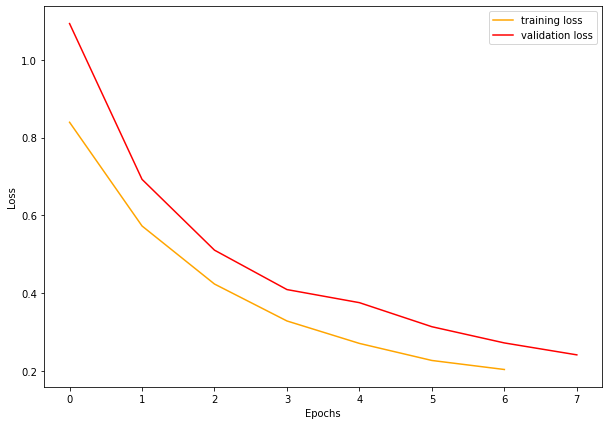

In [248]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss[1:], color='orange', label='training loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [151]:
def get_loss_dist(dataset, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    losses = []
    labels = []
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for i, (images, labs) in enumerate(dataloader):
            z, mp_inds = encoder(images)
            x_hat = decoder(z, mp_inds)
            for j in range(len(images)):
                img = images[j].unsqueeze(0)
                target = x_hat[j].unsqueeze(0)
                loss = criterion(img, target)
                losses.append(torch.mean(torch.max(loss, 1)[0]).item())
                labels.append(labs[j].item())
    return losses, labels

In [249]:
criterion = nn.MSELoss(reduction='none')
cases_set = CSVDataset(DATA_DIR, subject_group='case', decim_freqs=DECIM_FREQS)
loss_dist_test, labels_test = get_loss_dist(testset, encoder, decoder, criterion)
loss_dist_cases, labels_cases = get_loss_dist(cases_set, encoder, decoder, criterion)
loss_dist = loss_dist_test + loss_dist_cases
labels = labels_test + labels_cases

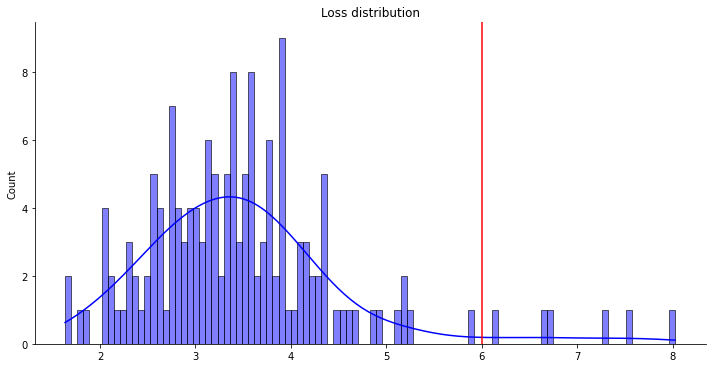

In [250]:
threshold = 6
sns.displot(loss_dist, bins=100, kde=True, color='blue', height=5, aspect=2)
plt.axvline(threshold, 0.0, 10, color='r')
plt.title('Loss distribution')
plt.show()

In [205]:
def print_results(loss_dist, labels, threshold):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    total_anom = 0
    
    for i in range(len(loss_dist)):
        label = labels[i]
        total_anom += label

        if loss_dist[i] >= threshold:
            if label == 1:
                tp += 1
            else:
                fp += 1
        else:
            if label == 1:
                fn += 1
            else:
                tn += 1
    print('[TP] {}\t\t[FP] {}\t\t[MISSED] {}'.format(tp, fp, total_anom-tp))
    print('[TN] {}\t\t[FN] {}'.format(tn, fn))

In [254]:
print_results(loss_dist, labels, 5)

[TP] 3		[FP] 8		[MISSED] 22
[TN] 120		[FN] 22
